# Simple biased coin model

This is a super simple model corresponding to the example shown in my slides. It is mainly meant as a guide for Pyro model syntax and the basic SVI loop, even though the example has an analytical solution.

In [453]:
import numpy as np
import torch
import pyro
import os
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
import pyro.poutine as poutine
from pyro.optim import Adam

# Data

We'll use two "datasets" corresponding to the example in the slides:
1. 5 coin tosses with 3 heads and 2 tails
2. 100 coin tosses with 80 heads and 20 tails

In [454]:
data1 = torch.tensor([1., 1., 1., 0., 0.])
data2 = torch.tensor([1. for _ in range(80)] + [0. for _ in range(20)])

## Model

First, define the "data-generating" model, sampling from our prior distribution for the coin probability.

Let's define two models with different priors; one uniform and one fairly certain that the coin is fair.

(Note that it doesn't matter, for the purposes of inference, whether the function has a return statement or not, since the named "sites" are all managed by Pyro beneath the hood)

In [455]:
def model_uni(data):
  p = pyro.sample("p", dist.Beta(1., 1.))
  
  with pyro.plate("data", len(data)):
    pyro.sample("obs", dist.Bernoulli(p), obs=data)


def model_fair(data):
  p = pyro.sample("p", dist.Beta(10., 10.))
  
  with pyro.plate("data", len(data)):
    pyro.sample("obs", dist.Bernoulli(p), obs=data)

We can display models using `pyro.render_model` (requires [graphviz](https://graphviz.org/download/) package):

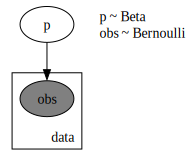

In [456]:
pyro.render_model(model_uni, model_args=(data1,), render_distributions=True, render_params=True)

# Guides

In order to do SVI, we need to define a guide function, which is also where we define the tunable parameters of the model.

Guides can be implemented using whichever distributions you like, but they must abide by the following rules:
* The function call signature must be the same as the call signature of your model.
* For each pyro.sample in your model (except for "obs"), the guide must have a corresponding pyro.sample with the same name and shape.

Note that, if we want to do MAP (a point estimate) rather than full posterior estimation, we can sample `p` from a Delta distribution rather than a Beta distribution. We will try both guides.

### Rules of thumb for creating guides:

* Make sure to constrain parameters to match the support of your distributions (e.g., alpha and beta should be constrained to positive numbers for a guide that uses the Beta distribution.)
* It's best to start with a more constrained guide (i.e., using MAP) to make sure the basic model is working.
* Initialization matters! You want to initialize your guide distribution to have low variance.

In [457]:
def guide_map(data):
    p = pyro.param("loc", torch.tensor(.5), constraint=constraints.unit_interval)
    pyro.sample("p", dist.Delta(p))

def guide(data):
    alpha = pyro.param("alpha", torch.tensor(20.), constraint=constraints.positive)
    beta = pyro.param("beta", torch.tensor(20.), constraint=constraints.positive)
    pyro.sample("p", dist.Beta(alpha, beta))

# SVI loop

To do SVI, we need two additional components besides the model and guide:

* An optimizer to do gradient descent steps -- in most cases you would just use Pyro's Adam wrapper.
* The ELBO loss function to use -- the simplest is `Trace_ELBO`, but there are others that I won't discuss today.

We loop for some number of iterations and use `svi.step()` to compute the ELBO and do gradient descent (this also returns the loss).

If fitting multiple models, you also need to use `pyro.clean_param_store()` to clear the parameters from the previous loop.

In [458]:
def fit(model, guide, data, lr=0.005, n_steps=1000, verbosity=100):
    pyro.clear_param_store()
    adam_params = {"lr": lr}
    adam = pyro.optim.Adam(adam_params)
    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for step in range(n_steps):
        loss = svi.step(data)
        if step % verbosity == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

def param(name):
    return pyro.get_param_store()[name].data.numpy()

# Experiments

First, some plotting code for plotting different distributions.

In [459]:
import matplotlib.pyplot as plt

def plot_beta(a, b, title=None):
    x = np.mgrid[0:1:0.01]
    plt.plot(
        x, 
        np.exp(dist.Beta(torch.tensor(a), torch.tensor(b)).log_prob(torch.tensor(x))),
        label=f"Beta({a}, {b})"
    )
    if title:
        plt.title(title)

def plot_delta(loc, tol=0.01, title=None):
    x = np.mgrid[0:1:0.01]
    def dirac(x, loc, tol):
        val = np.zeros_like(x)
        val[(loc - tol <= x) & (x <= loc + tol)] = 1
        return val
    plt.plot(
        x, 
        dirac(x, loc, tol),
        label=f"Delta({loc})"
    )
    if title:
        plt.title(title)

def plot_normal(loc, scale, title=None):
    x = np.mgrid[0:1:0.01]
    plt.plot(
        x, 
        np.exp(dist.Normal(torch.tensor(loc), torch.tensor(scale)).log_prob(torch.tensor(x))),
        label=f"Normal({loc}, {scale})"
    )
    if title:
        plt.title(title)

def plot_samples(samples, title=None):
    plt.hist(samples, range=[0,1], bins='auto', histtype='step')
    if title:
        plt.title(title)

## MAP Estimation

First, try the MAP estimate on both the initial 5 coin tosses, and the full 80 coin tosses. We'll try for both the uniform prior and the fair prior.

[iter 0]  loss: 3.4657
[iter 100]  loss: 3.3666
[iter 200]  loss: 3.3651
[iter 300]  loss: 3.3651
[iter 400]  loss: 3.3651
[iter 500]  loss: 3.3651
[iter 600]  loss: 3.3651
[iter 700]  loss: 3.3651
[iter 800]  loss: 3.3651
[iter 900]  loss: 3.3651
0.59999996


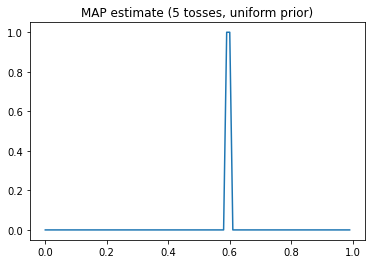

In [460]:
fit(model_uni, guide_map, data1)
loc = param("loc")
print(loc)
plot_delta(loc, title="MAP estimate (5 tosses, uniform prior)")

[iter 0]  loss: 69.3147
[iter 100]  loss: 58.1272
[iter 200]  loss: 53.0345
[iter 300]  loss: 51.0281
[iter 400]  loss: 50.3285
[iter 500]  loss: 50.1136
[iter 600]  loss: 50.0563
[iter 700]  loss: 50.0432
[iter 800]  loss: 50.0407
[iter 900]  loss: 50.0403
0.7998602


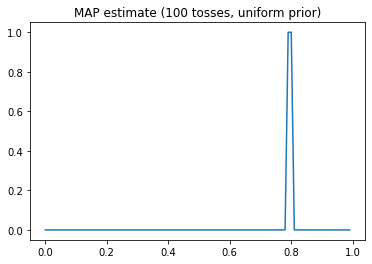

In [461]:
fit(model_uni, guide_map, data2)
loc = param("loc")
print(loc)
plot_delta(loc, title="MAP estimate (100 tosses, uniform prior)")

[iter 0]  loss: 2.2062
[iter 100]  loss: 2.1844
[iter 200]  loss: 2.1844
[iter 300]  loss: 2.1844
[iter 400]  loss: 2.1844
[iter 500]  loss: 2.1844
[iter 600]  loss: 2.1844
[iter 700]  loss: 2.1844
[iter 800]  loss: 2.1844
[iter 900]  loss: 2.1844
0.5217392


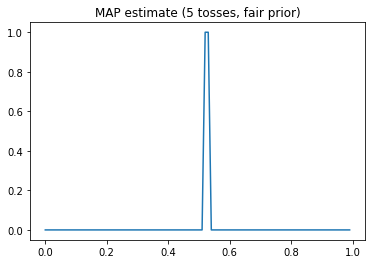

In [462]:
fit(model_fair, guide_map, data1)
loc = param("loc")
print(loc)
plot_delta(loc, title="MAP estimate (5 tosses, fair prior)")

[iter 0]  loss: 68.0551
[iter 100]  loss: 57.4775
[iter 200]  loss: 53.5248
[iter 300]  loss: 52.3777
[iter 400]  loss: 52.1168
[iter 500]  loss: 52.0711
[iter 600]  loss: 52.0650
[iter 700]  loss: 52.0644
[iter 800]  loss: 52.0643
[iter 900]  loss: 52.0643
0.75423473


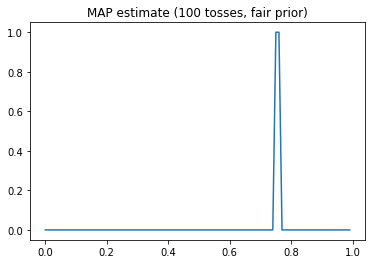

In [463]:
fit(model_fair, guide_map, data2)
loc = param("loc")
print(loc)
plot_delta(loc, title="MAP estimate (100 tosses, fair prior)")

## Posterior Estimation

Now we'll try full Bayesian estimation with a posterior distribution to represent uncertainty.

[iter 0]  loss: 4.4314
[iter 100]  loss: 1.8760
[iter 200]  loss: 4.7307
[iter 300]  loss: 2.8251
[iter 400]  loss: 4.5983
[iter 500]  loss: 4.4670
[iter 600]  loss: 3.0291
[iter 700]  loss: 4.5116
[iter 800]  loss: 4.3344
[iter 900]  loss: 4.2660
7.146712 5.222439


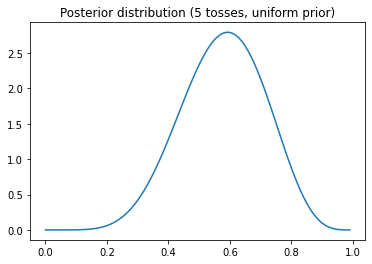

In [464]:
fit(model_uni, guide, data1)
a, b = param("alpha"), param("beta")
print(a, b)
plot_beta(a, b, title="Posterior distribution (5 tosses, uniform prior)")

[iter 0]  loss: 82.0682
[iter 100]  loss: 55.2112
[iter 200]  loss: 51.9852
[iter 300]  loss: 52.0201
[iter 400]  loss: 52.7148
[iter 500]  loss: 51.9913
[iter 600]  loss: 53.2703
[iter 700]  loss: 52.1149
[iter 800]  loss: 52.0648
[iter 900]  loss: 53.0461
43.138012 10.80551


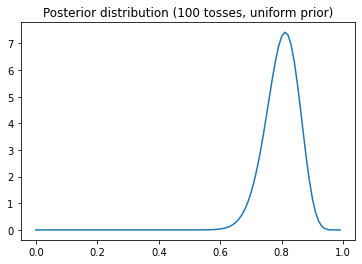

In [465]:
fit(model_uni, guide, data2)
a, b = param("alpha"), param("beta")
print(a, b)
plot_beta(a, b, title="Posterior distribution (100 tosses, uniform prior)")

[iter 0]  loss: 3.8505
[iter 100]  loss: 3.7428
[iter 200]  loss: 3.7790
[iter 300]  loss: 3.7076
[iter 400]  loss: 3.5945
[iter 500]  loss: 3.7076
[iter 600]  loss: 3.7191
[iter 700]  loss: 3.5614
[iter 800]  loss: 3.7051
[iter 900]  loss: 3.5624
16.77911 15.329649


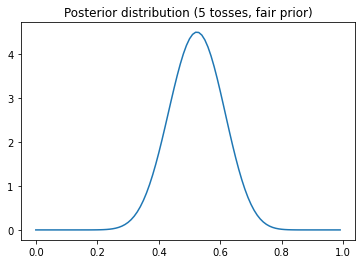

In [466]:
fit(model_fair, guide, data1)
a, b = param("alpha"), param("beta")
print(a, b)
plot_beta(a, b, title="Posterior distribution (5 tosses, fair prior)")

[iter 0]  loss: 92.1301
[iter 100]  loss: 59.3092
[iter 200]  loss: 54.1116
[iter 300]  loss: 54.0063
[iter 400]  loss: 54.2573
[iter 500]  loss: 53.9416
[iter 600]  loss: 55.5564
[iter 700]  loss: 56.1879
[iter 800]  loss: 55.3418
[iter 900]  loss: 56.0640
39.327156 13.344


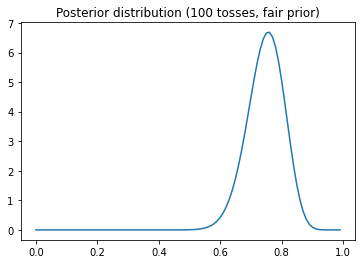

In [467]:
fit(model_fair, guide, data2)
a, b = param("alpha"), param("beta")
print(a, b)
plot_beta(a, b, title="Posterior distribution (100 tosses, fair prior)")

# AutoGuides

Pyro defines a number of helper functions to automatically create guides. Some common ones are AutoDelta (for MAP estimation) and AutoNormal. These will automatically create tunable parameters from the latent variable sites in your model.

You can control the parameter initialization using optional arguments -- for example:

```
AutoDelta(poutine.block(model, hide=["var1", "var2"]), 
          init_loc_fn=init_loc_fn)
```

The former argument will block sites `"var1"` and `"var2"` from becoming parameters, while `init_loc_fn` is some user-defined callable function that, given a site as input, returns an initial value for that site.

[iter 0]  loss: 59.4992
[iter 100]  loss: 52.7521
[iter 200]  loss: 50.6383
[iter 300]  loss: 50.1404
[iter 400]  loss: 50.0526
[iter 500]  loss: 50.0413
[iter 600]  loss: 50.0403
[iter 700]  loss: 50.0402
[iter 800]  loss: 50.0402
[iter 900]  loss: 50.0402
0.7999997


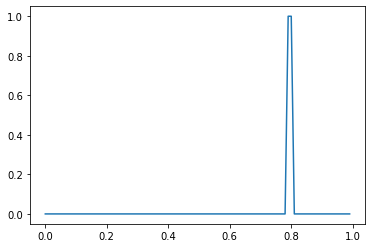

In [468]:
fit(model_uni, AutoDelta(model_uni), data2)
loc = param("AutoDelta.p")
print(loc)
plot_delta(loc)

# MCMC

Let's also try using MCMC to see how it works.

Sample: 100%|██████████| 1100/1100 [00:06, 181.88it/s, step size=8.74e-01, acc. prob=0.941]


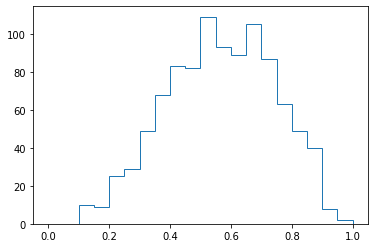

In [469]:
nuts_kernel_uni = NUTS(model_uni)

mcmc = MCMC(
    nuts_kernel_uni,
    num_samples=1000,
    warmup_steps=100,
    num_chains=1,
    )

mcmc.run(data1)
samples = mcmc.get_samples()

plot_samples(samples['p'].data.numpy())

Sample: 100%|██████████| 1100/1100 [00:04, 231.46it/s, step size=1.54e+00, acc. prob=0.797]


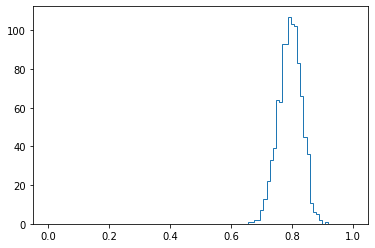

In [470]:
nuts_kernel_uni = NUTS(model_uni)

mcmc = MCMC(
    nuts_kernel_uni,
    num_samples=1000,
    warmup_steps=100,
    num_chains=1,
    )

mcmc.run(data2)
samples = mcmc.get_samples()

plot_samples(samples['p'].data.numpy())

Sample: 100%|██████████| 1100/1100 [00:07, 147.87it/s, step size=7.22e-01, acc. prob=0.966]


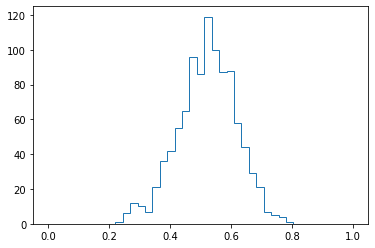

In [471]:
nuts_kernel_uni = NUTS(model_fair)

mcmc = MCMC(
    nuts_kernel_uni,
    num_samples=1000,
    warmup_steps=100,
    num_chains=1,
    )

mcmc.run(data1)
samples = mcmc.get_samples()

plot_samples(samples['p'].data.numpy())

Sample: 100%|██████████| 1100/1100 [00:07, 152.28it/s, step size=8.78e-01, acc. prob=0.953]


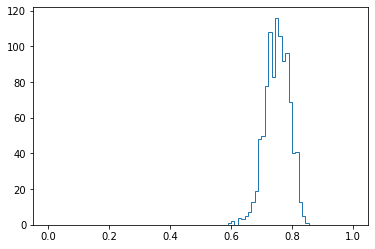

In [472]:
nuts_kernel_uni = NUTS(model_fair)

mcmc = MCMC(
    nuts_kernel_uni,
    num_samples=1000,
    warmup_steps=100,
    num_chains=1,
    )

mcmc.run(data2)
samples = mcmc.get_samples()

plot_samples(samples['p'].data.numpy())